<a href="https://colab.research.google.com/github/Jaimemorillo/ShouldIwatchThisMovie/blob/master/nice_movie_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import pandas as pd
import tensorflow as tf
import keras
import time
import numpy as np
from keras.utils import to_categorical
print(tf.__version__)

1.13.1


Using TensorFlow backend.


In [3]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

In [0]:
data = pd.read_csv("gdrive/My Drive/TFG/tmdb_spanish_overview.csv",sep='#',lineterminator='\n')

In [5]:
data = data[~pd.isna(data.overview)]
len(data)

4406

In [4]:
up = 7.3
under = 5

like = data[data.vote_average >= up]
dislike = data[data.vote_average <= under]
neutral = data.loc[(data['vote_average'] > under) & (data['vote_average'] < up )]

print(len(like))
print(len(dislike))
print(len(neutral))

571
614
3618


In [5]:
like.loc[:,'like'] = 1
neutral['like'] = neutral.vote_average.apply(lambda x: 0 if x < 5.9 else 1)
dislike.loc[:,'like'] = 0

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://

In [0]:
data = like.append(dislike)

In [7]:
len(data)

1185

In [0]:
import string

stop_words = pd.read_csv("gdrive/My Drive/TFG/stopwords-es.txt",header=None)
stop_words = stop_words[0].tolist()

def normalize(s):
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

def clean_overview(x):
    x = normalize(x.lower())
    """x = x.replace('.', ' <PERIOD>')
    x = x.replace(',', ' <COMMA>')
    x = x.replace(';', ' <SEMICOLON>')"""
    x = x.translate(str.maketrans('','',string.punctuation))
    x = x.translate(str.maketrans('','','1234567890ªº'))
    return x

def delete_stop_words(x):
    words = x.split(" ")
    words = [word for word in words if word not in stop_words]
    x = str(' '.join(words))
    return x


In [9]:

data['overview']=data['overview'].apply(lambda x: clean_overview(str(x)))
data['overview']=data['overview'].apply(lambda x: delete_stop_words(x))

neutral['overview']=neutral['overview'].apply(lambda x: clean_overview(str(x)))
neutral['overview']=neutral['overview'].apply(lambda x: delete_stop_words(x))

data


,Unnamed: 0,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,like
3,3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,años batman desaparecio dejando heroe converti...,112.312950,...,2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,1
6,6,260000000,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 10751...",http://disney.go.com/disneypictures/tangled/,38757,"[{""id"": 1562, ""name"": ""hostage""}, {""id"": 2343,...",en,Tangled,flynn rider buscado encantador bandido reino e...,48.681969,...,2010-11-24,591794936,100.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,They're taking adventure to new lengths.,Tangled,7.4,3330,1
7,7,280000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://marvel.com/movies/movie/193/avengers_ag...,99861,"[{""id"": 8828, ""name"": ""marvel comic""}, {""id"": ...",en,Avengers: Age of Ultron,tony stark reactivar programa caido desuso cuy...,134.279229,...,2015-04-22,1405403694,141.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,A New Age Has Come.,Avengers: Age of Ultron,7.3,6767,1
8,8,250000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://harrypotter.warnerbros.com/harrypottera...,767,"[{""id"": 616, ""name"": ""witch""}, {""id"": 2343, ""n...",en,Harry Potter and the Half-Blood Prince,desastres azotan inglaterra harry compañeros v...,98.885637,...,2009-07-07,933959197,153.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Dark Secrets Revealed,Harry Potter and the Half-Blood Prince,7.4,5293,1
16,16,220000000,"[{""id"": 878, ""name"": ""Science Fiction""}, {""id""...",http://marvel.com/avengers_movie/,24428,"[{""id"": 242, ""name"": ""new york""}, {""id"": 5539,...",en,The Avengers,enemigo inesperado surge amenaza seguridad mun...,144.448633,...,2012-04-25,1519557910,143.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Some assembly required.,The Avengers,7.4,11776,1
22,22,250000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://www.thehobbit.com/,57158,"[{""id"": 603, ""name"": ""elves""}, {""id"": 604, ""na...",en,The Hobbit: The Desolation of Smaug,sobrevivir inicio inesperado viaje compañia ca...,94.370564,...,2013-12-11,958400000,161.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Beyond darkness... beyond desolation... lies t...,The Hobbit: The Desolation of Smaug,7.6,4524,1
25,25,200000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""n...",http://www.titanicmovie.com,597,"[{""id"": 2580, ""name"": ""shipwreck""}, {""id"": 298...",en,Titanic,labores recuperacion restos famoso trasatlanti...,100.025899,...,1997-11-18,1845034188,194.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Nothing on Earth could come between them.,Titanic,7.5,7562,1
42,42,200000000,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 10751...",http://disney.go.com/toystory/,10193,"[{""id"": 1562, ""name"": ""hostage""}, {""id"": 3616,...",en,Toy Story 3,sabiendo dueño andy niño prepara universidad v...,59.995418,...,2010-06-16,1066969703,103.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,No toy gets left behind.,Toy Story 3,7.6,4597,1
44,44,190000000,"[{""id"": 28, ""name"": ""Action""}]",http://www.furious7.com/,168259,"[{""id"": 830, ""name"": ""car race""}, {""id"": 3428,...",en,Furious 7,problemas persiguen librarse mancha criminales...,102.322217,...,2015-04-01,1506249360,137.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Vengeance Hits Home,Furious 7,7.3,4176,1
46,46,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.x-menmovies.co

In [10]:
neutral

,Unnamed: 0,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,like
0,0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,año jake sully exmarine condenado vivir silla...,150.437577,...,2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,1
1,1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,siguiendo estela sucedido “piratas caribe cofr...,139.082615,...,2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,1
2,2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,criptico mensaje envia james bond mision secre...,107.376788,...,2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,1
4,4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,adaptacion ‘una princesa marte’ novela fantast...,43.926995,...,2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,1
5,5,258000000,"[{""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""na...",http://www.sonypictures.com/movies/spider-man3/,559,"[{""id"": 851, ""name"": ""dual identity""}, {""id"": ...",en,Spider-Man 3,entrega aventuras joven peter parker maguire p...,115.699814,...,2007-05-01,890871626,139.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,The battle within.,Spider-Man 3,5.9,3576,1
9,9,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.batmanvsupermandawnofjustice.com/,209112,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 7002...",en,Batman v Superman: Dawn of Justice,temor acciones cabo superman vigilante gotham ...,155.790452,...,2016-03-23,873260194,151.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Justice or revenge,Batman v Superman: Dawn of Justice,5.7,7004,0
10,10,270000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://www.superman.com,1452,"[{""id"": 83, ""name"": ""saving the world""}, {""id""...",en,Superman Returns,años misteriosa ausencia superman regresa tier...,57.925623,...,2006-06-28,391081192,154.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,NaN,Superman Returns,5.4,1400,0
11,11,200000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 28, ""...",http://www.mgm.com/view/movie/234/Quantum-of-S...,10764,"[{""id"": 627, ""name"": ""killing""}, {""id"": 1568, ...",en,Quantum of Solace,traicionado vesper mujer amaba plantea mision...,107.928811,...,2008-10-30,586090727,106.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,"For love, for hate, for justice, for revenge.",Quantum of Solace,6.1,2965,1
12,12,200000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,58,"[{""id"": 616, ""name"": ""witch""}, {""id"": 663, ""na...",en,Pirates of the Caribbean: Dead Man's Chest,will turner elizabeth swann casar hechos prisi...,145.847379,...,2006-06-20,1065659812,151.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Jack is back!,Pirates of the Caribbean: Dead Man

In [0]:
from sklearn.model_selection import train_test_split

overviews = data['overview'].values
y = data['like'].values

overviews_netutral =  neutral['overview'].values
y_netural = neutral['like'].values

overviews_train, overviews_test, y_train, y_test = train_test_split(overviews, y, test_size=0.1, random_state=777, stratify=y)

In [0]:
columns_train = {'Overview': overviews_train, 'Like': y_train}
train = pd.DataFrame(data=columns_train)
train.to_csv('train' + '.csv', sep=';', encoding='utf-8', index=False)

columns_test = {'Comment': overviews_test, 'Like': y_test}
test = pd.DataFrame(data=columns_test)
test.to_csv('test' + '.csv', sep=';', encoding='utf-8', index=False)

In [0]:
# Embedding
num_words = 10000
maxlen = 70
embedding_size = 2048

# Convolution
kernel_size = 3
filters = 250
pool_size = 2

hidden_dims = 250


# LSTM
lstm_output_size = 70

# Training
#lr=0.000005
lr=0.000003

In [14]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words) 
tokenizer.fit_on_texts(overviews_train)

X_train = tokenizer.texts_to_sequences(overviews_train) 
X_test = tokenizer.texts_to_sequences(overviews_test)
X_neutral = tokenizer.texts_to_sequences(overviews_netutral)

vocab_size = len(tokenizer.word_index) + 1 # Adding 1 because of reserved 0 index

print(overviews_train[2]) 
print(X_train[2]) 
print(vocab_size)

problemas coche pista estrella reagan farrow boondocks florida acepta oferta ayuda par extraños encantadores encontrarse atrapados pesadilla brutal backwoods retirado cautivo cabaña aislada reagan logra escapar refugiarse bosque incesantemente perseguido sociopatas salvajes secuestraron reagan necesitara fuerza interior inventiva sobrevivir emocionante thriller  unsullied largometraje independiente inspirado historia real historia reagan farrow atleta secuestrado luchar sobrevivir escapar capturas huir oscuridad salvaje desconocido
[114, 287, 491, 88, 1356, 2701, 4564, 1036, 435, 4565, 29, 579, 580, 4566, 1037, 1831, 492, 1832, 4567, 490, 4568, 1038, 1039, 1356, 493, 102, 1833, 325, 4569, 2702, 4570, 1040, 4571, 1356, 4572, 115, 436, 2703, 141, 581, 2704, 4573, 1357, 1358, 1834, 6, 94, 6, 1356, 2701, 1359, 494, 116, 141, 102, 4574, 1835, 2705, 437, 1041]
11167


In [15]:
from collections import OrderedDict

dictWords = dict(tokenizer.word_counts)

print(len(dictWords) + 1)

for k,v in list(dictWords.items()):
    if v < 2 :
        del dictWords[k]
        
print(len(dictWords) + 1) 
# Para establecer el tamaño de maxlen

len(max(X_train, key=len))

11167
4557


82

In [16]:
from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_neutral = pad_sequences(X_neutral, padding='post', maxlen=maxlen)

X_train[1]

array([2695,  578, 2696, 2697,  433, 1826, 4563,   50, 2698,   93,  684,
        490,  162, 1355, 2699, 1034,   16, 1355, 2699, 1827, 1828,  578,
       1829, 2700,  101,  434, 1035, 1830,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0], dtype=int32)

In [0]:
from keras import backend as K
from keras.callbacks import EarlyStopping

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[0]
    K.get_session().run(tf.local_variables_initializer())
    return auc

#Optimizer

from keras import optimizers

adam = optimizers.Adam(lr)


es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=20,
                   verbose=0, mode='auto')

In [18]:
from sklearn.utils import class_weight


class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

#class_weights[1] = class_weights[1] * 3
class_weights

array([0.96557971, 1.03696498])

In [22]:
# Model 1

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, GlobalMaxPool1D

model = Sequential()

model.add(Embedding(vocab_size,embedding_size, input_length=maxlen))
model.add(GlobalMaxPool1D())
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(500, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['acc',precision,recall])

model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 70, 2048)          22896640  
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              2049000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_3 (Dense)              (None, 100)               50100     
___________________________

In [21]:
# Model 2


from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D

model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(vocab_size,
                    embedding_size,
                    input_length=maxlen))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
#model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy',precision])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 70, 2048)          22870016  
_________________________________________________________________
dropout_1 (Dropout)          (None, 70, 2048)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 68, 250)           1536250   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               62750     
_________________________________________________________________
activation_1 (Activation)    (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 251       
__________

In [22]:
history = model.fit(X_train, y_train,
                    epochs=500,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=16, callbacks=[es], class_weight = class_weights)

Train on 1066 samples, validate on 119 samples
Epoch 1/500
1066/1066 [==============================] - 14s 13ms/step - loss: 0.6946 - acc: 0.5178 - precision: 0.0000e+00 - val_loss: 0.6932 - val_acc: 0.5210 - val_precision: 0.0000e+00
Epoch 2/500
1066/1066 [==============================] - 3s 3ms/step - loss: 0.6877 - acc: 0.5178 - precision: 0.0000e+00 - val_loss: 0.6901 - val_acc: 0.5210 - val_precision: 0.0000e+00
Epoch 3/500
1066/1066 [==============================] - 3s 3ms/step - loss: 0.6820 - acc: 0.5178 - precision: 0.0000e+00 - val_loss: 0.6873 - val_acc: 0.5210 - val_precision: 0.0000e+00
Epoch 4/500
1066/1066 [==============================] - 3s 3ms/step - loss: 0.6768 - acc: 0.5169 - precision: 0.0000e+00 - val_loss: 0.6844 - val_acc: 0.5294 - val_precision: 0.0588
Epoch 5/500
1066/1066 [==============================] - 3s 3ms/step - loss: 0.6725 - acc: 0.5188 - precision: 0.0150 - val_loss: 0.6820 - val_acc: 0.5210 - val_precision: 0.0588
Epoch 6/500
1066/1066 [=====

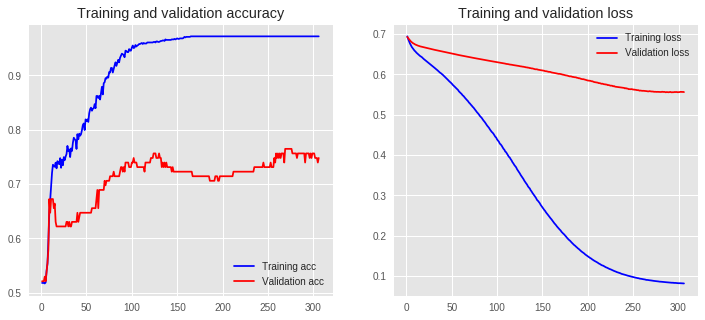

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history)

In [24]:
y_pred = model.predict_classes(X_test)
y_score = model.predict(X_test)
#y_pred= model.predict_classes(X_neutral)
#y_test = y_netural

"""for idx,p in enumerate(y_score):
    if p >= 0.5:
        y_pred[idx] = 1
    else:
        y_pred[idx] = 0"""

'for idx,p in enumerate(y_score):\n    if p >= 0.5:\n        y_pred[idx] = 1\n    else:\n        y_pred[idx] = 0'

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

print("Confusion Matrix: \n" + str(confusion_matrix(y_test, y_pred)))
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("Kappa: {:.4f}".format(cohen_kappa_score(y_test, y_pred)))
print("Precision: {:.4f}".format(precision_score(y_test, y_pred,pos_label=1)))
print("Recall: {:.4f}".format(recall_score(y_test, y_pred,pos_label=1)))
print("F1: {:.4f}".format(f1_score(y_test, y_pred,pos_label=1)))
print("Auc: {:.4f}".format(roc_auc_score(y_test, y_pred)))

Confusion Matrix: 
[[49 13]
 [17 40]]
Accuracy: 0.7479
Kappa: 0.4935
Precision: 0.7547
Recall: 0.7018
F1: 0.7273
Auc: 0.7460


In [0]:
model.save('nice_movie' + '_model.h5')  

In [30]:
!pip install tmdbsimple

import tmdbsimple as tmdb

tmdb.API_KEY = '38dd5c6c01713ef99903275d51e2fd68'

In [0]:
def get_niceness(film):
  
  search = tmdb.Search()
  response = search.movie(query=film,language='es-ES')
  
  print(response)
  

  if len(response['results']) >= 1:
    over = response['results'][0]['overview']

    over = clean_overview(str(over))
    over = delete_stop_words(over)

    X_over = tokenizer.texts_to_sequences(np.array([over]))
    X_over = pad_sequences(X_over, padding='post', maxlen=maxlen)

    y_over = model.predict_classes(X_over)

    return str(y_over[0][0])
  
  else:
    
    return 'No existe la peli'
  

In [107]:
get_niceness("la naranja")

{'page': 1, 'total_results': 4, 'total_pages': 1, 'results': [{'vote_count': 6292, 'id': 185, 'video': False, 'vote_average': 8.2, 'title': 'La naranja mecánica', 'popularity': 20.454, 'poster_path': '/2jA1D4NAKzBwGjd5NumFrB67cG3.jpg', 'original_language': 'en', 'original_title': 'A Clockwork Orange', 'genre_ids': [878, 18], 'backdrop_path': '/unMc1jEyqCnzba976GviSFKGagt.jpg', 'adult': False, 'overview': 'Gran Bretaña, en un futuro indeterminado. Alex (Malcolm McDowell) es un joven muy agresivo que tiene dos pasiones: la violencia desaforada y Beethoven. Es el jefe de la banda de los drugos, que dan rienda suelta a sus instintos más salvajes apaleando, violando y aterrorizando a la población. Cuando esa escalada de terror llega hasta el asesinato, Alex es detenido y, en prisión, se someterá voluntariamente a una innovadora experiencia de reeducación que pretende anular drásticamente cualquier atisbo de conducta antisocial.', 'release_date': '1971-12-18'}, {'vote_count': 13, 'id': 64034

'1'

In [0]:
word_embds = model.layers[1].get_weights()[0]
word_list = []
for word, i in tokenizer.word_index.items():
    word_list.append(word)

In [0]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(word_embds)
number_of_words = 1000
trace = go.Scatter(
    x = X_embedded[0:number_of_words,0], 
    y = X_embedded[0:number_of_words, 1],
    mode = 'markers',
    text= word_list[0:number_of_words]
)
layout = dict(title= 't-SNE 1 vs t-SNE 2 for sirst 1000 words ',
              yaxis = dict(title='t-SNE 2'),
              xaxis = dict(title='t-SNE 1'),
              hovermode= 'closest')
fig = dict(data = [trace], layout= layout)
py.iplot(fig)

In [0]:
import xgboost as xgb

#model = xgb.XGBClassifier(max_depth=10,n_estimators=150,silent=False,objective='binary:logistic')
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [0]:
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test!

In [0]:
!pip install finetune

In [20]:
from finetune import Classifier

model = Classifier()               # Load base model
model.fit(X_train, y_train)          # Finetune base model on custom data
y_pred = model.predict(X_test)

INFO:finetune:Saving tensorboard output to /tmp/Finetunef9d3zaxi


AttributeError: ignored